# KNN Time Series Forecasting for NVIDIA Stock Prices

## Data Extraction

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from datetime import datetime
from sklearn.model_selection import train_test_split


import yfinance as yf

In [57]:
# Define the stock list
stocks_list = ['NVDA']

# Define the date range
end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

# Download stock data
for stock in stocks_list:
    globals()[stock] = yf.download(stock, start, end)

# Reset the index and rename columns
NVDA.reset_index(inplace=True)
NVDA.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Check for NaN values in each column
print("\nNumber of NaN values in each column:")
print(NVDA.isna().sum())

[*********************100%%**********************]  1 of 1 completed


Number of NaN values in each column:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


## Data Pre-Processing

In [58]:
# Create a new data frame with Close
nvidia_data = NVDA[['Date', 'Close']]

# Drop rows where 'Close' is NaN
nvidia_data = nvidia_data.dropna(subset=['Close'])

In [59]:
# Convert Date from Timestamp to Ordinal
nvidia_data['Date_ord'] = nvidia_data['Date'].map(pd.Timestamp.toordinal)

In [60]:
# Scale Close Values
# Create X and y Vars
X = nvidia_data[['Date_ord']]
scaler = StandardScaler()
nvidia_data['Close'] = scaler.fit_transform(nvidia_data[['Close']])
y = nvidia_data['Close']
#y = (nvidia_data['Close'] - nvidia_data['Close'].mean()) / nvidia_data['Close'].std()


In [61]:
# Print the first few rows of the scaled data
print("Scaled data:")
print(nvidia_data.head())

Scaled data:
        Date     Close  Date_ord
0 2022-10-31 -1.255879    738459
1 2022-11-01 -1.253656    738460
2 2022-11-02 -1.246374    738461
3 2022-11-03 -1.257335    738462
4 2022-11-04 -1.245889    738463


In [62]:
# Split Data into Train and Test Sets
# 80/20 Train/Test Ratio
# shuffle is false to keep it in order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [63]:
# Print the first few rows of the training data
print("Training data:")
print(X_train.head())
print(y_train.head())

# Check variance in training data
print("Variance in training data:")
print(np.var(X_train), np.var(y_train))

Training data:
   Date_ord
0    738459
1    738460
2    738461
3    738462
4    738463
0   -1.255879
1   -1.253656
2   -1.246374
3   -1.257335
4   -1.245889
Name: Close, dtype: float64
Variance in training data:
Date_ord    28596.684667
dtype: float64 0.43578244531779736


## K-Nearest Neighbors (KNN)

In [64]:
# Define a function to build, fit, and evaluate the KNN model
def evaluate_knn(n_neighbors):
    print(f"\nTrying n_neighbors = {n_neighbors}")
    
    # Build Model and Fit
    knn_model = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)

    # Predict
    y_pred = knn_model.predict(X_test)

    # Print the raw predictions
    # print("Raw predictions:")
    # print(y_pred)

    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_scaled = scaler.inverse_transform(y_test.to_numpy().reshape(-1, 1)).flatten()

    # Print the predictions after inverse scaling
    # print("Predictions after inverse scaling:")
    # print(y_pred)
    
    # Evaluate KNN Model using RMSE
    knn_rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))
    print(f'Root Mean Squared Error: {knn_rmse}')

    # Convert Ordinal Date back to Timestamp for plotting
    X_test_dates = X_test['Date_ord'].map(pd.Timestamp.fromordinal)
    X_train_dates = X_train['Date_ord'].map(pd.Timestamp.fromordinal)

    # Visualize the data
    plt.figure(figsize=(16, 6))
    plt.title(f'Model with n_neighbors = {n_neighbors}')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(X_test_dates, y_test_scaled, label='Actual')
    plt.plot(X_test_dates, y_pred, label='Prediction')
    plt.plot(X_train_dates, scaler.inverse_transform(y_train.values.reshape(-1, 1)).flatten(), label='Train')
    plt.legend(loc='lower right')
    plt.show()

    # Evaluate how well the KNN model performs.
    # If the predictions perfectly match the actual values, the points should align along a straight line with a slope of 1.

    plt.figure(figsize=(10, 6))

    # Scatter plot of predicted vs. actual values
    plt.scatter(y_pred, y_test_scaled, alpha=0.7)
    plt.title(f'Predicted vs. Actual Values with n_neighbors = {n_neighbors}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], color='red')  # Line of perfect prediction
    plt.show()


Trying n_neighbors = 1
Root Mean Squared Error: 9.845200438683866


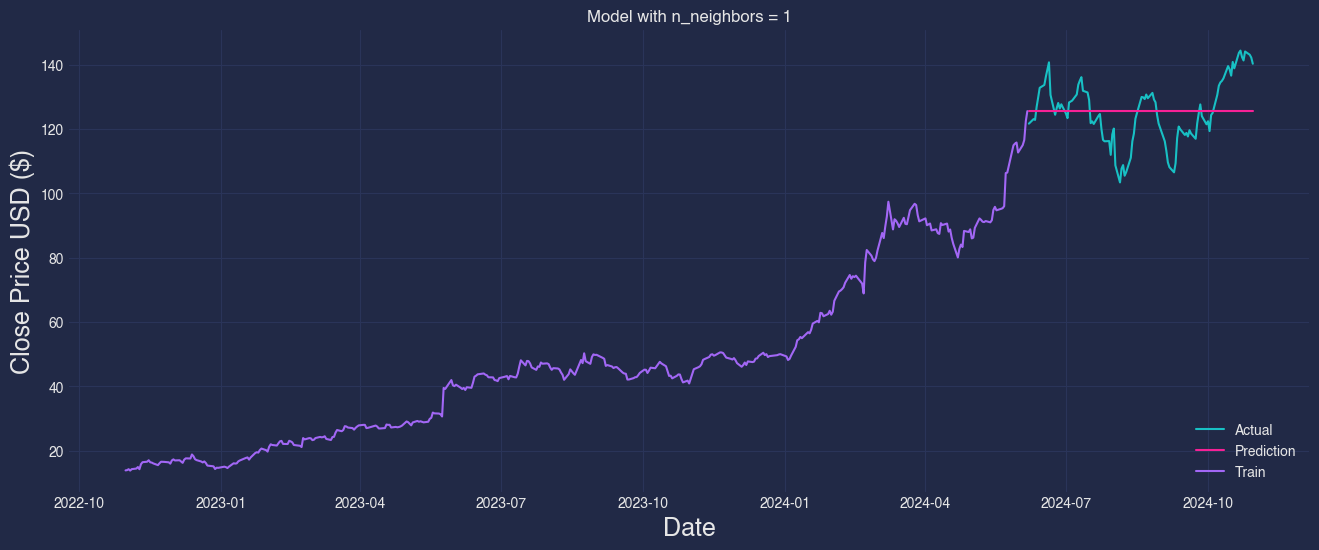

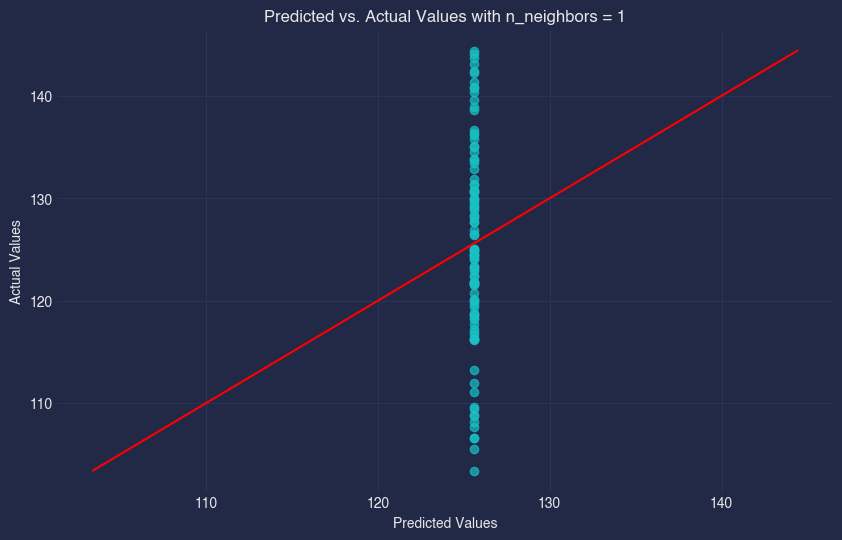


Trying n_neighbors = 3
Root Mean Squared Error: 10.577470873449608


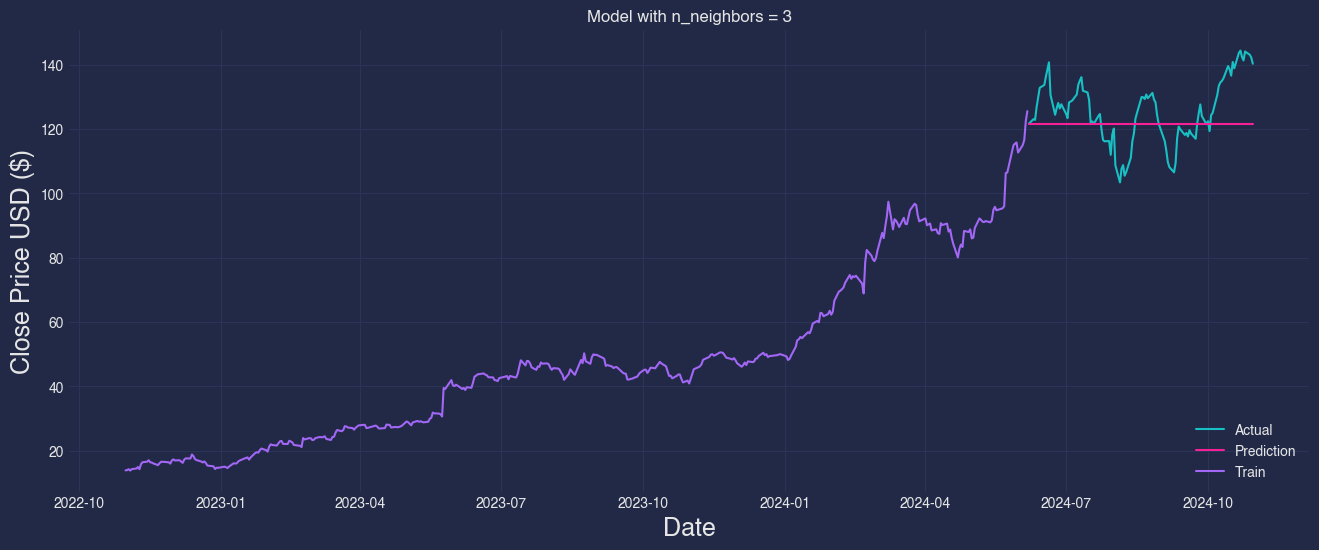

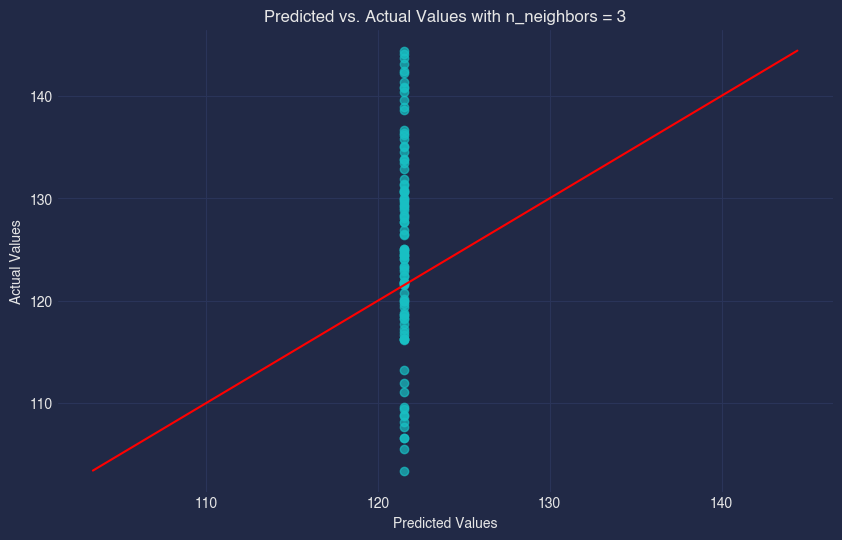


Trying n_neighbors = 5
Root Mean Squared Error: 12.047447382415628


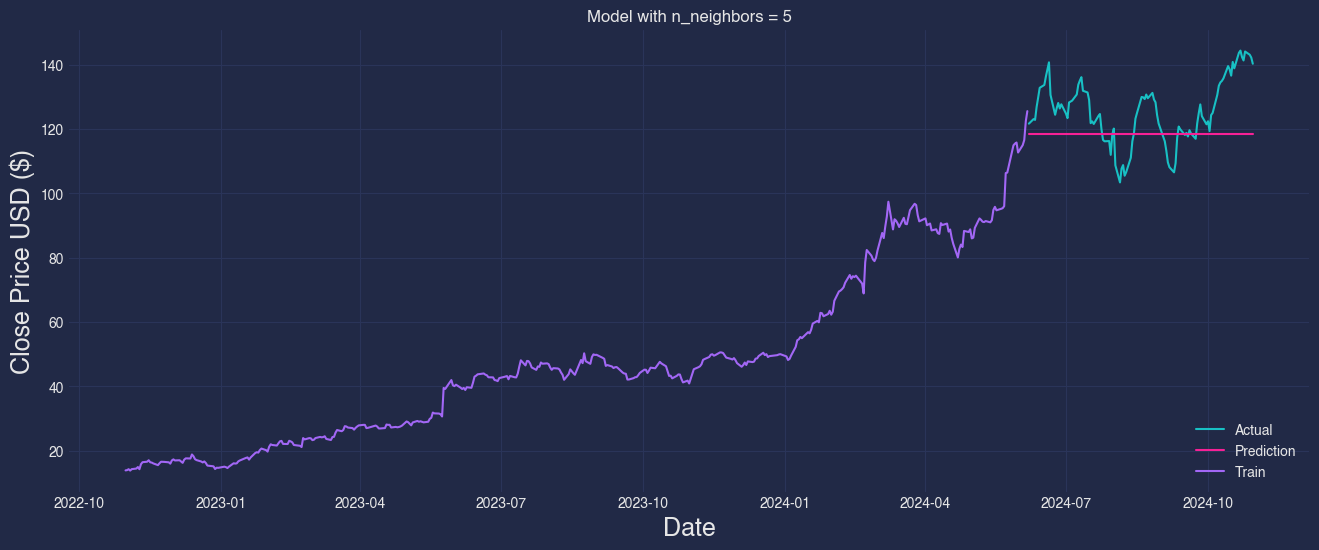

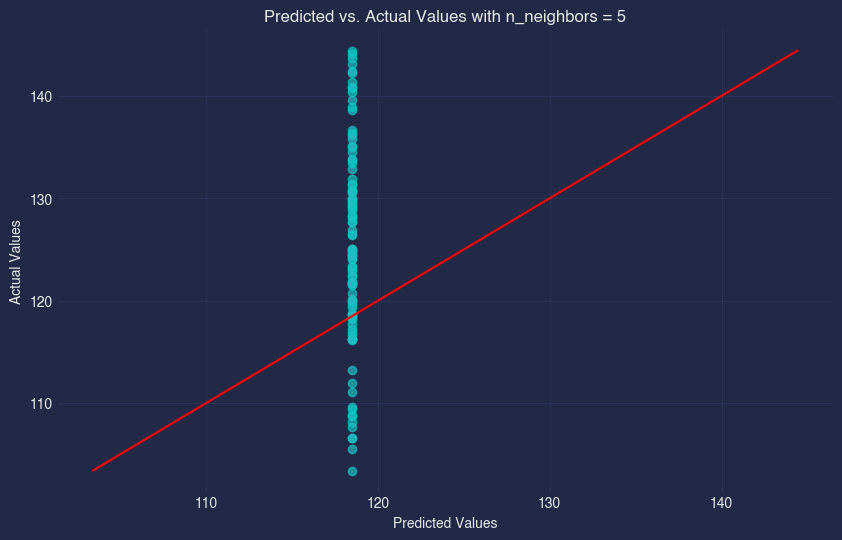


Trying n_neighbors = 7
Root Mean Squared Error: 12.52840365244527


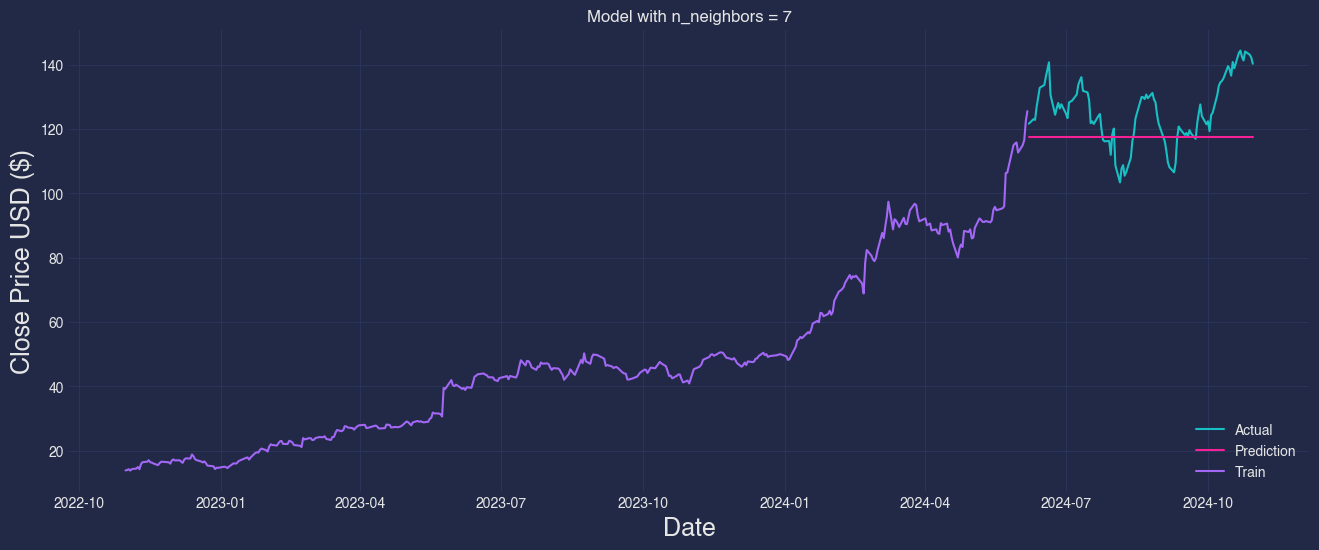

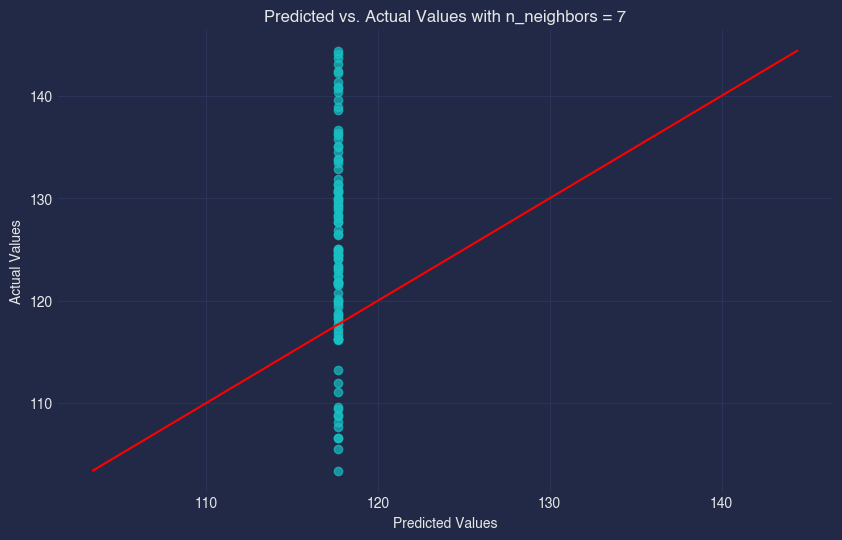


Trying n_neighbors = 10
Root Mean Squared Error: 14.230404475829545


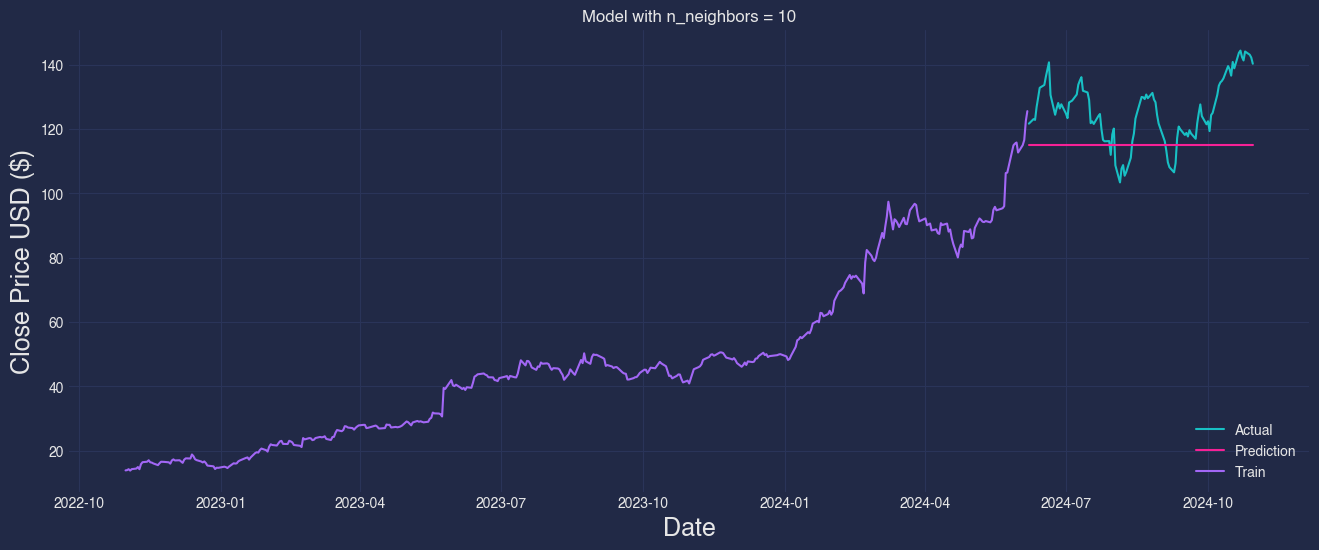

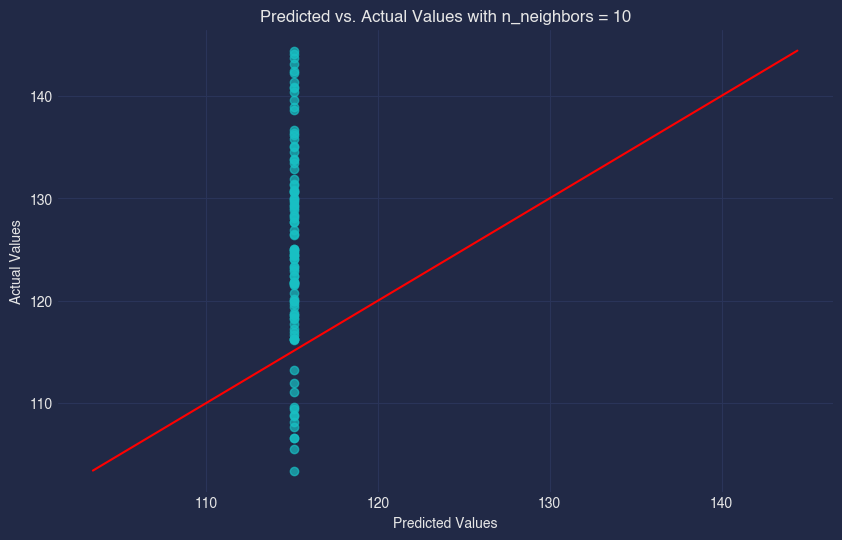

In [65]:
# Try different values for n_neighbors
for n_neighbors in [1, 3, 5, 7, 10]:
    evaluate_knn(n_neighbors)